In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(1)



blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices
from src.utils.general_old import get_selectivity, get_cos_sim_torch

In [3]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 5
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge_replay"] = 1
network_parameters["max_semantic_charge_input"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 250])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/25])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/25])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf


network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0.005
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.03
network_parameters["ctx_mtl_sparse_std"] = 0.005
network_parameters["ctx_mtl_sparse_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = np.inf
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = np.inf
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = np.inf
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf

In [4]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [5]:
input_params = {}
input_params["num_days"] = 100
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]


latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


In [6]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB)
selectivity_mtl_sparse, ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB)
selectivity_mtl_dense, ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB)

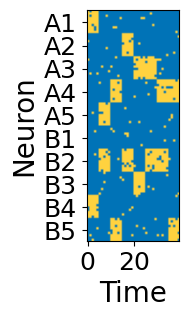

In [7]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["sen"], dim=0)[network.awake_indices][:input_params["day_length"], :100].reshape(-1, 100).T, cmap=blue_yellow)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)


plt.savefig('Figures_SVG/5a1.svg', dpi=300, transparent=True)

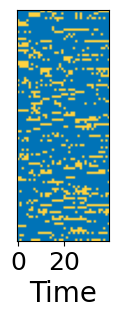

In [8]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][:input_params["day_length"], :100][:, ordered_indices_mtl_dense].reshape(-1, 100).T, cmap=blue_yellow)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)


plt.savefig('Figures_SVG/5a2.svg', dpi=300, transparent=True)

In [9]:
input_params = {}
input_params["num_days"] = 100
input_params["day_length"] = 200
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


In [10]:
input_params = {}
input_params["num_days"] = 1900
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

In [11]:
latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
#network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
torch.save(network, "network_5_interleaved.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850


In [15]:
ordered_indices_ctx, ordered_indices_mtl, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy_A, accuracy_B, episode_slectivity_ctx = get_selectivity(network, input_latents, input_episodes, input_params, latent_specs)

torch.Size([350, 4000]) torch.Size([4000, 10])
mtl_sparse classification accuracy (A+B joint): 0.1637
mtl_sparse classification accuracy (A only): 0.2250
mtl_sparse classification accuracy (B only): 0.4852


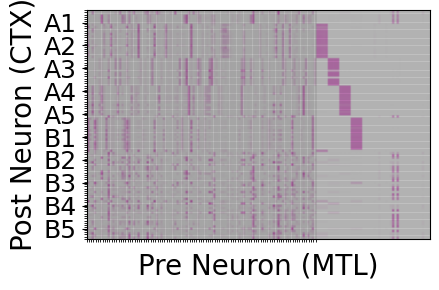

In [16]:
fig = plt.figure(figsize=(4.5, 4.5))

# Compute the full indexing array
full_ordered_indices = torch.cat([
    ordered_indices_mtl_dense,
    network.mtl_dense_size + ordered_indices_mtl_sparse
])

plt.imshow(network.ctx_mtl[ordered_indices_ctx][:100][:, full_ordered_indices[:-50]], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)
plt.tight_layout()

In [17]:
input_params = {}
input_params["num_days"] = 10
input_params["day_length"] = 200
input_params["mean_duration"] = 1
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]


latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
0
0
0
0
0
0
0
0
0


In [18]:
input_params = {}
input_params["num_days"] = 1900
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0 if i==j else 1/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
torch.save(network, "network_5_blocked.pt")


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850


In [19]:
ordered_indices_ctx, ordered_indices_mtl, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy_A, accuracy_B, _ = get_selectivity(network, input_latents, input_episodes, input_params, latent_specs)

torch.Size([350, 4000]) torch.Size([4000, 10])
mtl_sparse classification accuracy (A+B joint): 0.5997
mtl_sparse classification accuracy (A only): 0.9320
mtl_sparse classification accuracy (B only): 0.9800


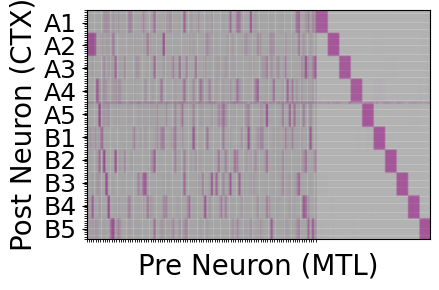

In [21]:
fig = plt.figure(figsize=(4.5, 4.5))

# Compute the full indexing array
full_ordered_indices = torch.cat([
    ordered_indices_mtl_dense,
    network.mtl_dense_size + ordered_indices_mtl_sparse
])

plt.imshow(network.ctx_mtl[ordered_indices_ctx][:100][:, full_ordered_indices[:-50]], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)
plt.tight_layout()

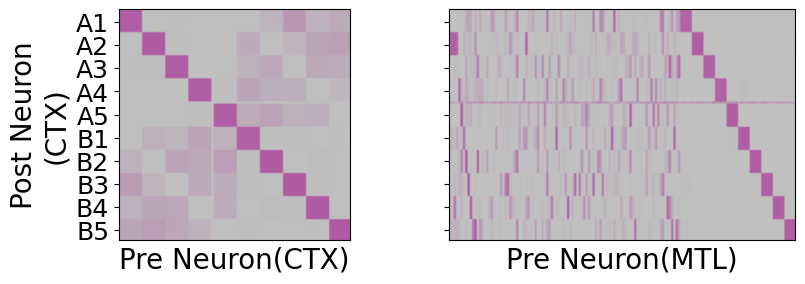

In [20]:
# Compute the full indexing array
full_ordered_indices = torch.cat([
    ordered_indices_mtl_dense,
    network.mtl_dense_size + ordered_indices_mtl_sparse
])


fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, gridspec_kw={'wspace': 0})  # 1 row, 2 columns

# First image
im0 = axes[0].imshow(network.ctx_ctx[ordered_indices_ctx][:, ordered_indices_ctx][:100][:, :100], cmap=gray_purple)
axes[0].set_xlabel("Pre Neuron(CTX)", fontsize=20)
axes[0].set_ylabel("Post Neuron\n(CTX)", fontsize=20)
axes[0].set_xticks([])


# Second image
im1 = axes[1].imshow(network.ctx_mtl[ordered_indices_ctx][:100][:, full_ordered_indices[:-50]], cmap=gray_purple)
axes[1].set_xticks([])
axes[1].set_xlabel("Pre Neuron(MTL)", fontsize=20)



# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
axes[0].set_yticks(positions, labels, fontsize=18)

plt.subplots_adjust(wspace=0)
plt.margins(0,0)

plt.show()

In [10]:
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

In [11]:
input_params["num_days"] = 10
input_params["day_length"] = 200
input_params["mean_duration"] = 1

latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)


prototype_A = torch.zeros(latent_specs["dims"][0], network.mtl_dense_size)
replayed_A =  torch.zeros(latent_specs["dims"][0], input_params["num_days"]*network.sleep_duration_A, network.mtl_dense_size)
prototype_B = torch.zeros(latent_specs["dims"][1], network.mtl_dense_size)
replayed_B =  torch.zeros(latent_specs["dims"][0],  input_params["num_days"]*network.sleep_duration_A, network.mtl_dense_size)

network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

replayed_A[0] = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.sleep_indices_A]
prototype_A[0] = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.awake_indices].mean(axis=0)
network.awake_indices = []
network.sleep_indices_A = []


0


In [12]:
for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
    replayed_A[k] = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.sleep_indices_A]
    prototype_A[k] = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.awake_indices].mean(axis=0)
    network.awake_indices = []
    network.sleep_indices_A = []


0
0
0
0


In [13]:
for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
    prototype_B[k] = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.awake_indices].mean(axis=0)
    replayed_B[k] = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.sleep_indices_A]
    network.awake_indices = []
    network.sleep_indices_A = []

0
0
0
0
0


In [14]:
def get_max_overlap(replayed, prototpyes):
    cos_sims = [get_cos_sim_torch(replayed, prototype) for prototype in prototpyes]
    max_sim = torch.max(torch.stack(cos_sims, dim=0))
    return max_sim.item()

In [15]:

prototypes = torch.concat([prototype_A, prototype_B], axis=0)
max_overlaps_blocked = []
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[0]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[1]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[2]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[3]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[4]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[0]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[1]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[2]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[3]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[4]])

In [16]:
mtl_dense_sen = network.mtl_dense_sen.clone()

In [17]:
input_params["num_days"] = 100
input_params["day_length"] = 200
input_params["mean_duration"] = 1
latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
network.mtl_dense_sen = mtl_dense_sen
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


In [18]:
replayed_interleaved = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.sleep_indices_A]
max_overlaps_interleaved = [get_max_overlap(replayed, prototypes) for replayed in replayed_interleaved]

In [19]:
blocked_index = np.array(max_overlaps_blocked).argsort()[500]
print(blocked_index)

854


In [44]:
 [get_cos_sim_torch(replayed_A[2][35], prototype) for prototype in prototypes]

[tensor(0.1084),
 tensor(0.0754),
 tensor(0.7095),
 tensor(0.2182),
 tensor(0.0981),
 tensor(0.2009),
 tensor(0.3544),
 tensor(0.1952),
 tensor(0.1658),
 tensor(0.2899)]

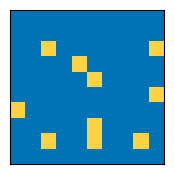

In [49]:
fig = plt.figure(figsize=(2, 2))

plt.imshow(replayed_A[2][35].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])

plt.savefig('Figures_SVG/5g1.svg', dpi=300, transparent=True)

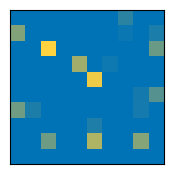

In [50]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(prototype_A[2].reshape(-1, 10), vmin=0.4, cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/5g2.svg', dpi=300, transparent=True)

In [40]:
interleaved_index = np.array(max_overlaps_interleaved).argsort()[500]
print(interleaved_index)

506


In [46]:
[get_cos_sim_torch(replayed_interleaved[506], prototype) for prototype in prototypes]

[tensor(0.2776),
 tensor(0.5906),
 tensor(0.1160),
 tensor(0.3479),
 tensor(0.1616),
 tensor(0.4558),
 tensor(0.2319),
 tensor(0.1047),
 tensor(0.4672),
 tensor(0.1753)]

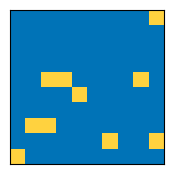

In [51]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(replayed_interleaved[506].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/5g3.svg', dpi=300, transparent=True)

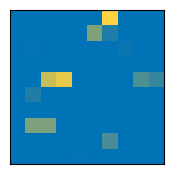

In [52]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(prototype_A[1].reshape(-1, 10), vmin=0.4, cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/5g4.svg', dpi=300, transparent=True)

/var/folders/jp/4cgfm60j5y9bnfwq3whjps6m0000gn/T/ipykernel_1804/3403997787.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


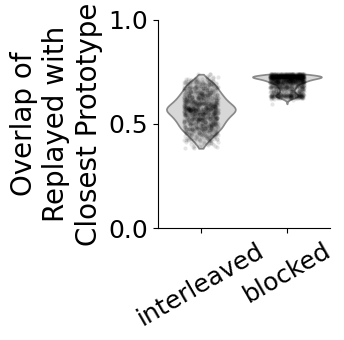

In [20]:
# Flatten your arrays
interleaved_vals = max_overlaps_interleaved
blocked_vals = max_overlaps_blocked

# Combine them for plotting
data = np.concatenate([interleaved_vals, blocked_vals])
groups = (['interleaved'] * len(interleaved_vals) + 
          ['blocked'] * len(blocked_vals))


palette = {
    "interleaved": "#D3D3D3",   # light blue
    "blocked": "#D3D3D3"
}

plt.figure(figsize=(3.5, 3.5))
sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)
sns.stripplot(x=groups, y=data, color='k', alpha=0.1, jitter=0.2, size=3)
plt.ylabel("Overlap of\nReplayed with\nClosest Prototype", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()

sns.despine()

plt.savefig('Figures_SVG/5h.svg', dpi=300, transparent=True)
